In [2]:
from preprocess import pipelines
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [34]:
data=pipelines.make_pipeline(inter_dataset_path='../data/intermediate/inter_medpix.csv',
                        image_size=(299, 299),downscale=True,
                        shuffle=True,
                        seed=1,fractions=[0.90,0.05,0.05])

making input pipeline


# The configuration dictionary

In [143]:
# Unpack parameters
config={
    'seq_len':128,
    'num_heads':3,
    'model_dim':728,
    'dropout':0.2,
    'img_backbone_trainable':False,
    'img_size':(299,299,3),
    'img_backbone':'efficientnetb0',
    'intermediate_size':728*4,  
    
}


# The tokenizer

In [79]:
# Toeknize sequence through a map function on training validation and test set

# Initialize tokenizer
tokenizer=tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=config['seq_len'],
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,

)

# Get the training texts
training_texts=data['captioning']['train'].map(lambda x:x['text'])
training_images=data['captioning']['train'].map(lambda x:x['image'])
# Adapt the tokenizer
# tokenizer.adapt(training_texts)

# The model

## Image encoder layer
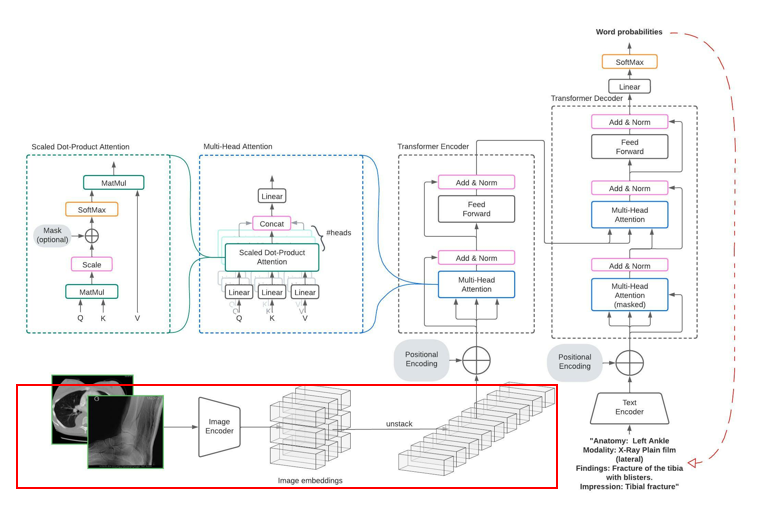

In [137]:
# The encoder layer

# The image encoder class
class ImageEncoder(tf.keras.layers.Layer):
    def __init__(self,config):
        """
        Image encoder class. 
        
        The layer takes images and returns a sequence of vectors 
        corresponding to the last convolutional volume of the given 
        backbone network after being projected to the model's dimension
        "model_dim". 
        
        Args: 
            config(dict): A configuration dictionary. Must contain keys:
                'img_backbone_trainable': whether the backbone is trainable
                'img_size': the resolution of the image ex: (299,299,3)
                'img_backbone': Currently only efficientnetB0 is implemented
        """
        super().__init__()
        # Base attrobites 
        self.backbone = config['img_backbone']
        self.img_size = config['img_size']
        self.img_backbone_trainable = config['img_backbone_trainable']
        
        # Initialize backbone model
        self.backbone_model = None # initialized bellow in init_backbone()
        self.init_backbone()
        self.backbone_model.trainable=config['img_backbone_trainable']  # set bakcbone trainability
        
        # Other model params
        self.reshape = tf.keras.layers.Reshape(
            (-1,self.backbone_model.output.shape[-1])
        )
        self.projection = tf.keras.layers.Dense(config['model_dim'])
    def call(self,inputs):
        x=self.backbone_model(inputs)
        x=self.reshape(x)
        x=self.projection(x)
        return x
    
    def init_backbone(self):
        """Initializes the backbone model."""
        
        if self.backbone=='efficientnetb0':
            # Notice that the images must be in float format (299,299,3) and go from 0 to 255
            self.backbone_model = tf.keras.applications.efficientnet.EfficientNetB0(
                input_shape=self.img_size, include_top=False, weights="imagenet",
            )
        # Implement other backbones here
        else: 
            # If backbone is not recognized.
            print(f'backbone {self.backbone} not implemented')
        
        # Set backbone model trainability. 
        self.backbone_model.trainable = self.img_backbone_trainable
        
        
        

### Image encoder tests

In [141]:
# Tests
# Image encoder test
image_encoder = ImageEncoder(config)
for inputs in training_images.batch(32).take(1):
    print(f'Before ImageEncoder: {inputs.shape}')
    x=image_encoder(inputs)
    print(f'After ImageEncoder: {x.shape}')

Before ImageEncoder: (32, 299, 299, 3)
After ImageEncoder: (32, 100, 728)


## Positional embedding layer
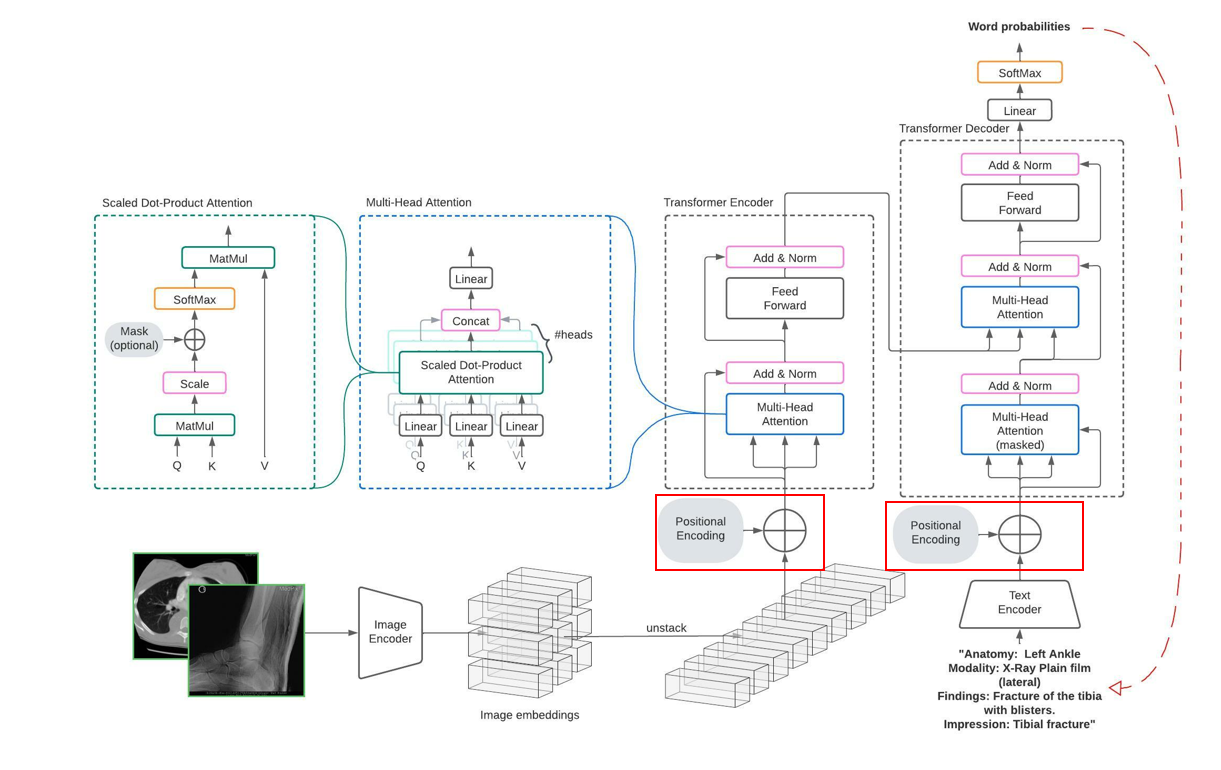

In [135]:
class PositionalEncoder(tf.keras.layers.Layer):
    """A layer that adds positional encoding to a squence of embeddings."""
    def __init__(self,config,sequence_length,**kwargs):
        """Initialize a positional encoder. 
        
        Creates an learnable embedding matrix to represent positions for
        positional encoding. It also scales the resulting embeddings by the 
        square_root of the model dimension. 
        
        Args: 
        config(dict): A configuration dictionary that must contain:
            model_dim: The size of the embeddings. Typically 728.
        sequence_length: The size of the sequence for positional encoding. 
        """
        super().__init__(**kwargs)
        
        
        self.sequence_length=sequence_length
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=config['model_dim']
        )
        self.scale=tf.math.sqrt(tf.cast(config['model_dim'],tf.float32))

    def call(self,inputs):
        
        length = tf.shape(inputs)[-2] # Length of the sequence
        positions = tf.range(start=0, limit=length, delta=1) # Indexes of the positions
        embedded_positions = self.position_embeddings(positions)
        output_embedding=embedded_positions
        scaled_inputs=self.scale*inputs
        return output_embedding+inputs
    

### Positional embedding layer tests

In [142]:
image_encoder = ImageEncoder(config)
positional_encoder = PositionalEncoder(config,sequence_length=100)
for inputs in training_images.batch(32).take(1):
    print(f'Before ImageEncoder: {inputs.shape}')
    x=image_encoder(inputs)
    print(f'After ImageEncoder: {x.shape}')
    x=positional_encoder(x)
    print(f'After PositionalEncoder: {x.shape}')

Before ImageEncoder: (32, 299, 299, 3)
After ImageEncoder: (32, 100, 728)
After PositionalEncoder: (32, 100, 728)


## Transformer encoder layer

### The feedforward network
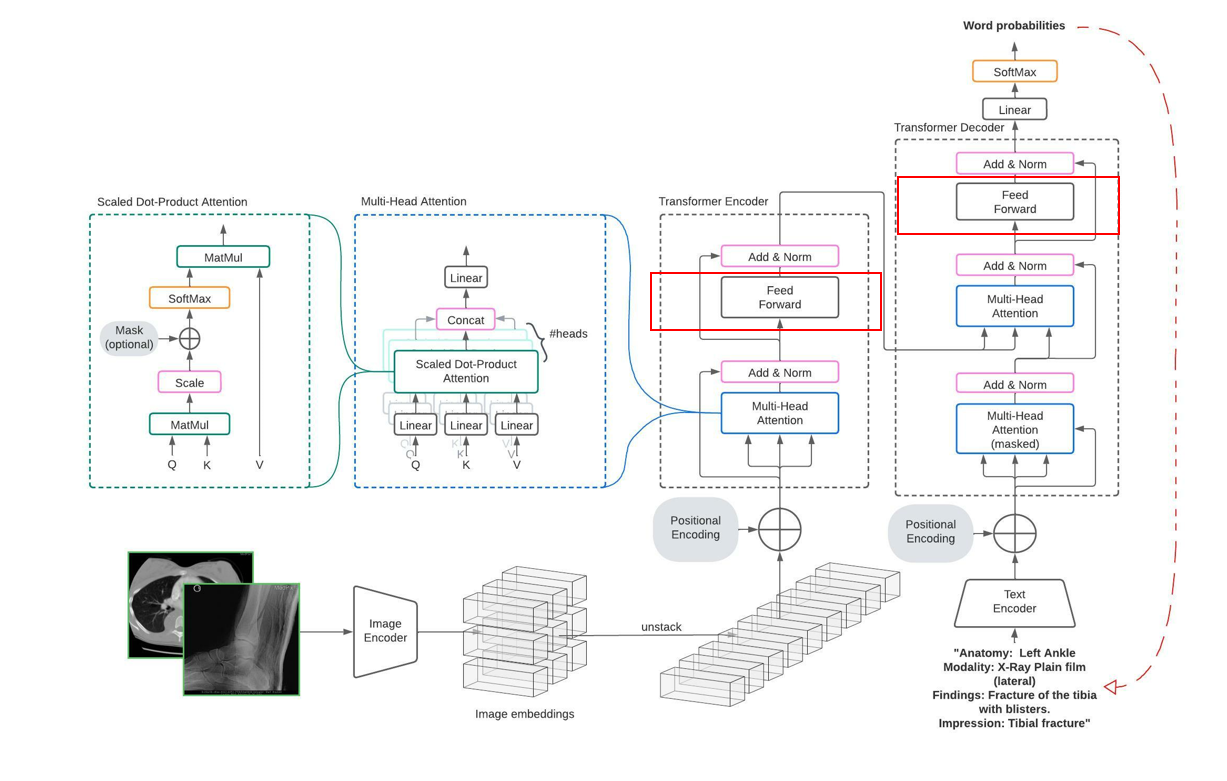

In [154]:
class FeedForward(tf.keras.layers.Layer):
    """The feed forward network of the transformer. 
    
    A dense feed forward network that operates on each embedding individually. 
    It is composed by two linear layers with a gelu activation in between. 
    """
    def __init__(self,config):
        """Initializes layers for feedforward network. 
        
        Args: 
            config(dict): A configuration dictionary that must contain: 
                'intermediate_size': An int with the size of the intermediate
                    layer. 
                'model_dim': The dimension of the transformer embeddings.
                'dropout': The dropout rate.         """
        super().__init__()
        self.linear_1 = tf.keras.layers.Dense(config['intermediate_size'],
                                             activation='gelu')
        self.linear_2 = tf.keras.layers.Dense(config['model_dim'])
        
        self.dropout = tf.keras.layers.Dropout(config['dropout'])
    
    def call(self,inputs):
        x=self.linear_1(inputs)
        x=self.linear_2(x)
        x=self.dropout(x)
        return x
        
            
    

#### Feedforward test

In [152]:
feed_forward=FeedForward(config)
inputs= tf.random.uniform(shape=(64,100,728))
print(f'Before FeedForward network: {inputs.shape}')
x = feed_forward(inputs)
print(f'After FeedForward network:{inputs.shape}')


Before FeedForward network: (64, 100, 728)
After FeedForward network:(64, 100, 728)


### TranformerEncoder
We decided to post layer normalization because this is how the original captioning model worked in keras example 
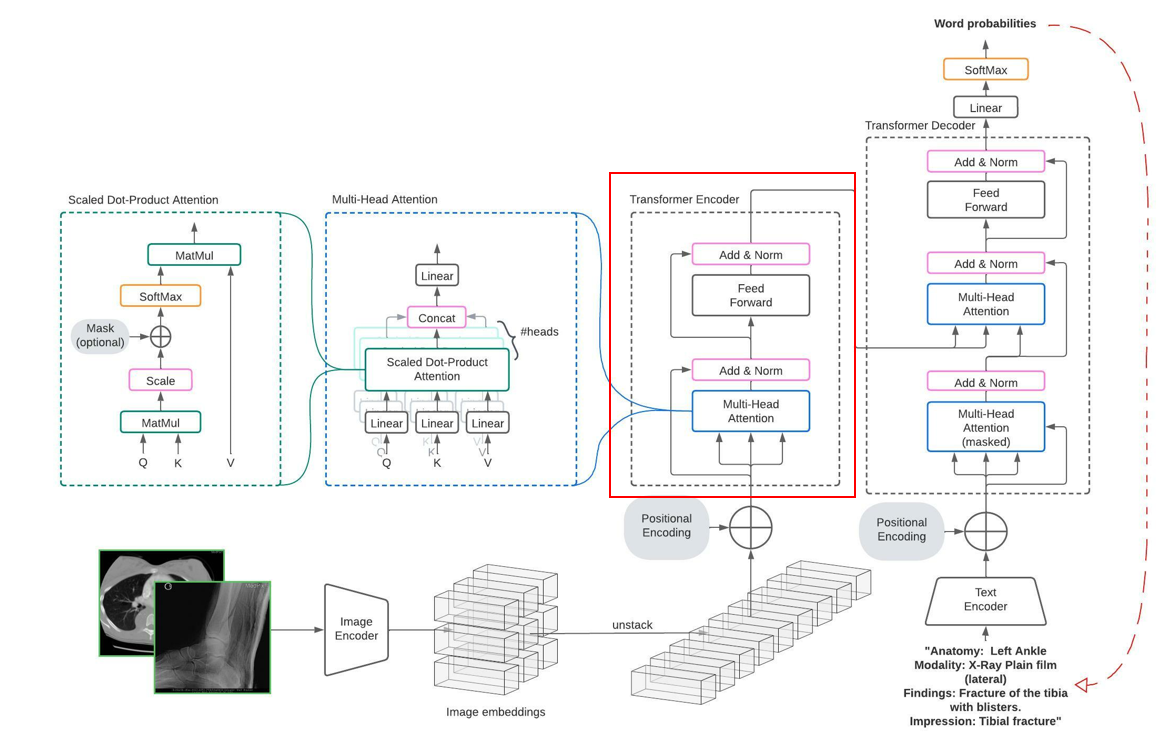


In [1]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self,config):
        super().__init__( )
        self.layer_norm_1=tf.keras.layers.LayerNormalization()
        self.layer_norm_2=tf.keras.layers.LayerNormalization()
        self.mha=tf.keras.layers.MultiHeadAttention(
            num_heads=config['num_heads'],
            key_dim=100, # The dimensions of the dot product for attention in every head
            value_dim=None,
            dropout=0.0
        )
        self.ffw=FeedForward(config)
    def call(self,inputs):
        x=self.mha(inputs)
        x1=self.layer_norm_1(x+inputs)
        x=self.ffw(x1)
        x=self.layer_norm_2(x+x1)
        return(x)

NameError: name 'tf' is not defined